# This notebook will contain feature engineering steps:

- Encoding categorical variables

- Feature scaling (e.g., standardization, normalization)

- Feature selection (optional)

- Creating new features (if applicable)

In [53]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

### Input 01-notebook file

In [54]:
path = '../data/cleaned/heart_2022_cleaned_01.csv'

In [55]:
# read data
df = pd.read_csv(path ,sep=',',encoding='utf-8')
df.sample(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartAttack_bin,HeartAttackBinary
13210,Arizona,Male,Very good,3.0,1.0,Within past year (anytime less than 12 months ...,Yes,7.0,1 to 5,Yes,...,29.53,Yes,No,Yes,No,"No, did not receive any tetanus shot in the pa...",No,No,1,1
28446,California,Male,Good,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,None of them,Yes,...,20.36,No,Yes,Yes,Yes,"Yes, received Tdap",No,No,1,1
50006,Connecticut,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,25.79,Yes,Yes,No,No,"Yes, received tetanus shot but not sure what type",No,Yes,0,0
21929,Arkansas,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,None of them,No,...,27.44,Yes,No,No,No,"Yes, received Tdap",No,Tested positive using home test without a heal...,0,0
15402,Arizona,Female,Fair,15.0,30.0,Within past year (anytime less than 12 months ...,No,3.0,"6 or more, but not all",No,...,58.95,No,Yes,No,No,"No, did not receive any tetanus shot in the pa...",Yes,No,0,0


In [56]:
df.info()
df = df.drop(columns = ["HadHeartAttack_bin", "HeartAttackBinary"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59903 entries, 0 to 59902
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State                      59903 non-null  object 
 1   Sex                        59903 non-null  object 
 2   GeneralHealth              59903 non-null  object 
 3   PhysicalHealthDays         59903 non-null  float64
 4   MentalHealthDays           59903 non-null  float64
 5   LastCheckupTime            59903 non-null  object 
 6   PhysicalActivities         59903 non-null  object 
 7   SleepHours                 59903 non-null  float64
 8   RemovedTeeth               59903 non-null  object 
 9   HadHeartAttack             59903 non-null  object 
 10  HadAngina                  59903 non-null  object 
 11  HadStroke                  59903 non-null  object 
 12  HadAsthma                  59903 non-null  object 
 13  HadSkinCancer              59903 non-null  obj

> Calculate correlation between each feature


📊 數值變數之間的相關係數熱力圖（Pearson）:


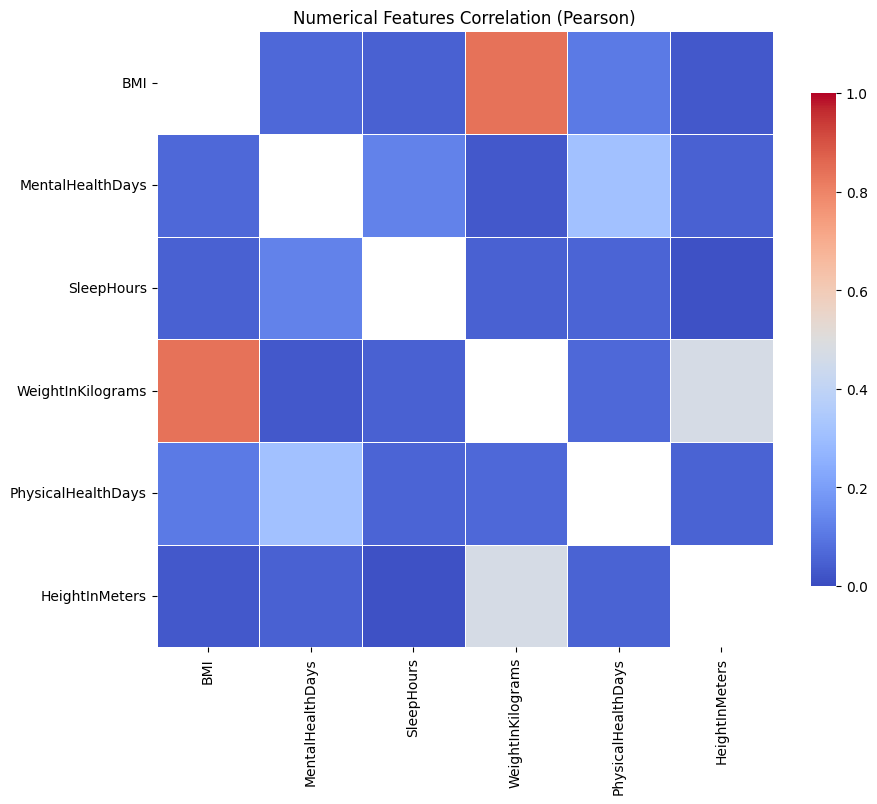


📊 類別變數之間的相關係數熱力圖（Cramér's V）:


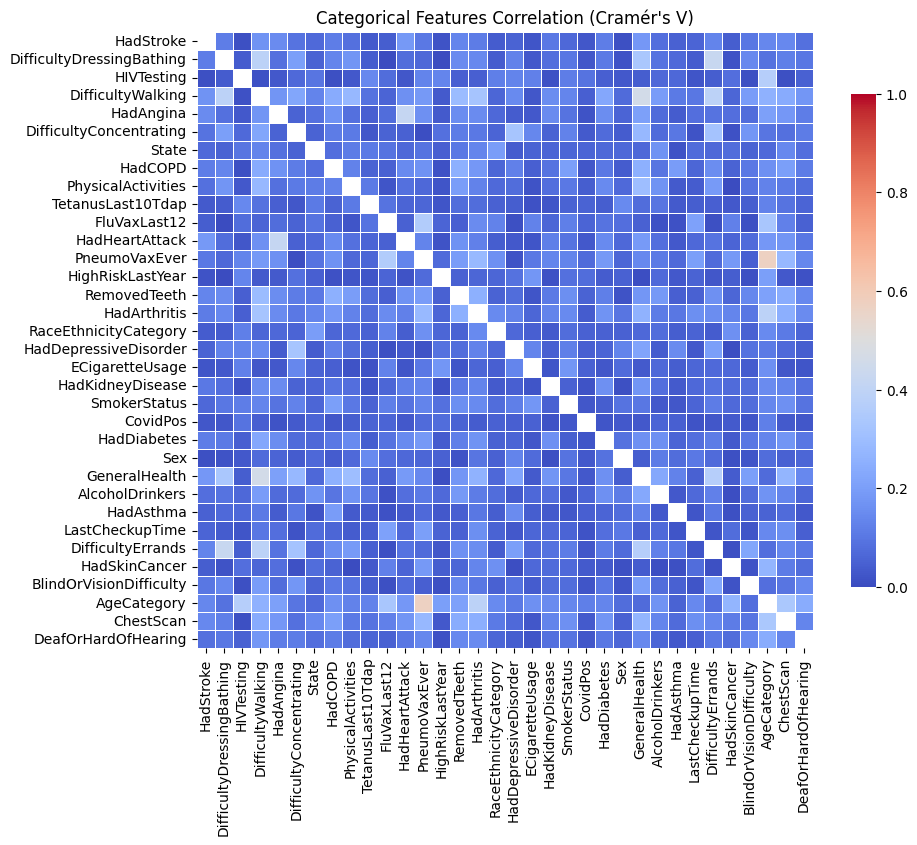


📊 數值與類別變數之間的相關係數熱力圖（Point Biserial）:


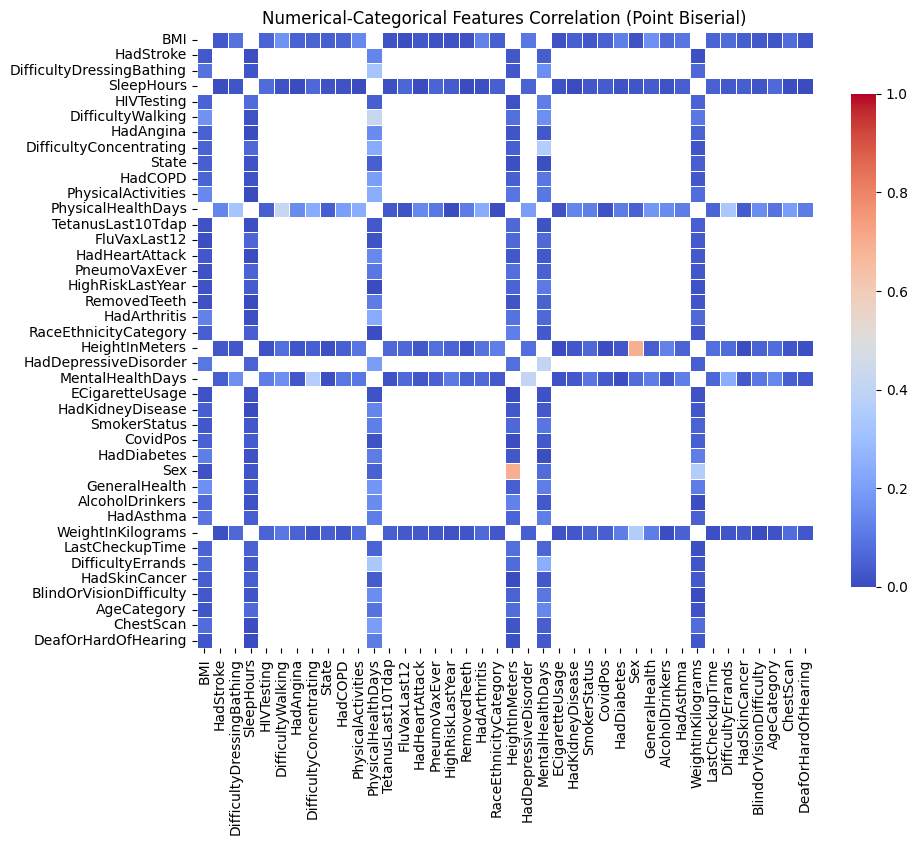

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, chi2_contingency

# === 計算 Cramér's V (類別變數之間) ===
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
        return 0.0
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    phi2 = chi2 / n
    return np.sqrt(phi2 / min(k - 1, r - 1)) if min(k - 1, r - 1) > 0 else 0.0

# === 計算 Point Biserial Correlation (數值與類別) ===
def point_biserial(x, y):
    try:
        corr, _ = pointbiserialr(x, y)
        return abs(corr)
    except Exception:
        return np.nan

# === 特徵分類 ===
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# === 計算特徵之間的相關係數 ===
cat_corr = {}  # 類別變數之間的 Cramér's V
num_corr = {}  # 數值變數之間的 Pearson 相關係數
mix_corr = {}  # 數值與類別變數之間的 Point Biserial 相關係數

# === 計算類別變數之間的相關係數 (Cramér's V) ===
for i, col1 in enumerate(cat_cols):
    for col2 in cat_cols[i+1:]:
        v = cramers_v(df[col1], df[col2])
        cat_corr[(col1, col2)] = v

# === 計算數值變數之間的相關係數 (Pearson) ===
for i, col1 in enumerate(num_cols):
    for col2 in num_cols[i+1:]:
        try:
            corr = df[col1].corr(df[col2], method='pearson')
            num_corr[(col1, col2)] = abs(corr)
        except Exception:
            num_corr[(col1, col2)] = np.nan

# === 計算數值變數與類別變數之間的相關係數 (Point Biserial) ===
for col1 in cat_cols:
    for col2 in num_cols:
        try:
            x = df[col2].astype(float)
            y = pd.factorize(df[col1])[0]
            corr = point_biserial(x, y)
            if not np.isnan(corr):
                mix_corr[(col1, col2)] = corr
        except Exception:
            mix_corr[(col1, col2)] = np.nan

# === 將相關係數轉為 DataFrame 格式 ===
def dict_to_matrix(corr_dict):
    cols = list(set([key[0] for key in corr_dict.keys()] + [key[1] for key in corr_dict.keys()]))
    matrix = pd.DataFrame(np.nan, index=cols, columns=cols)
    for (col1, col2), value in corr_dict.items():
        matrix.loc[col1, col2] = value
        matrix.loc[col2, col1] = value  # 對稱矩陣
    return matrix

# 轉換相關係數字典為 DataFrame
num_corr_df = dict_to_matrix(num_corr)
cat_corr_df = dict_to_matrix(cat_corr)
mix_corr_df = dict_to_matrix(mix_corr)

# === 繪製相關係數熱力圖 (無數字標註) ===
def plot_heatmap(corr_df, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_df, cmap='coolwarm', vmin=0, vmax=1, linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
    plt.title(title)
    plt.show()

# 數值變數相關係數熱力圖
print("\n📊 數值變數之間的相關係數熱力圖（Pearson）:")
plot_heatmap(num_corr_df, "Numerical Features Correlation (Pearson)")

# 類別變數相關係數熱力圖
print("\n📊 類別變數之間的相關係數熱力圖（Cramér's V）:")
plot_heatmap(cat_corr_df, "Categorical Features Correlation (Cramér's V)")

# 數值與類別變數之間的相關係數熱力圖
print("\n📊 數值與類別變數之間的相關係數熱力圖（Point Biserial）:")
plot_heatmap(mix_corr_df, "Numerical-Categorical Features Correlation (Point Biserial)")


In [58]:
# import pandas as pd
# import numpy as np
# from scipy.stats import pointbiserialr, chi2_contingency

# def cramers_v(x, y):
#     confusion_matrix = pd.crosstab(x, y)
#     if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
#         return 0.0
#     chi2, _, _, _ = chi2_contingency(confusion_matrix)
#     n = confusion_matrix.sum().sum()
#     r, k = confusion_matrix.shape
#     phi2 = chi2 / n
#     return np.sqrt(phi2 / min(k - 1, r - 1)) if min(k - 1, r - 1) > 0 else 0.0

# # 預設 target 已經 LabelEncoded 成 0/1
# target = "HadHeartAttack"

# cat_cols = df.select_dtypes(include=["object", "category"]).columns.drop(target, errors="ignore").tolist()
# num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# df["HadHeartAttack_bin"] = df["HadHeartAttack"].map({"Yes": 1, "No": 0})
# # === 類別型欄位：Cramér's V ===
# cat_corr = {}
# for col in cat_cols:
#     valid = df[[col, target]]
#     if not valid.empty:
#         cat_corr[col] = cramers_v(valid[col], valid[target])

# # === 數值型欄位：Point Biserial Correlation ===
# num_corr = {}
# for col in num_cols:
#     valid = df[[col, "HadHeartAttack_bin"]]
#     try:
#         x = valid[col].astype(float)
#         y = valid["HadHeartAttack_bin"].astype(int)
#         corr, _ = pointbiserialr(x, y)
#         if np.isscalar(corr) and not np.isnan(corr):  # 確保是數值且不是 NaN
#             num_corr[col] = abs(corr)
#     except Exception as e:
#         print(f"{col} 計算錯誤：{e}")

# # === 排序與輸出 ===
# sorted_cat = sorted(cat_corr.items(), key=lambda x: float(x[1]), reverse=True)
# sorted_num = sorted(num_corr.items(), key=lambda x: float(x[1]), reverse=True)

# print("\n📊 數值型特徵與目標變數的相關係數（Point Biserial）:")
# for col, score in sorted_num:
#     print(f"{col}: {score:.4f}")
# print("📊 類別型特徵與目標變數的相關係數（Cramér’s V）:")
# for col, score in sorted_cat:
#     print(f"{col}: {score:.4f}")


### Encoding

In [59]:
col_obj = df.select_dtypes('object').columns

le = LabelEncoder()

for col in col_obj:
    df[col] = le.fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59903 entries, 0 to 59902
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State                      59903 non-null  int64  
 1   Sex                        59903 non-null  int64  
 2   GeneralHealth              59903 non-null  int64  
 3   PhysicalHealthDays         59903 non-null  float64
 4   MentalHealthDays           59903 non-null  float64
 5   LastCheckupTime            59903 non-null  int64  
 6   PhysicalActivities         59903 non-null  int64  
 7   SleepHours                 59903 non-null  float64
 8   RemovedTeeth               59903 non-null  int64  
 9   HadHeartAttack             59903 non-null  int64  
 10  HadAngina                  59903 non-null  int64  
 11  HadStroke                  59903 non-null  int64  
 12  HadAsthma                  59903 non-null  int64  
 13  HadSkinCancer              59903 non-null  int

In [60]:
df.sample(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
23756,3,0,2,0.0,0.0,3,1,8.0,3,0,...,1.60,98.430,38.44,0,0,0,0,1,0,2
33325,4,0,4,0.0,0.0,3,1,7.0,3,0,...,1.65,67.130,25.04,1,0,1,1,1,0,0
55962,6,0,2,6.0,0.0,3,1,10.0,0,0,...,1.57,79.605,29.76,0,1,1,0,1,0,0
15235,2,0,4,1.0,0.0,3,1,4.0,3,0,...,1.52,65.770,28.32,0,0,0,1,2,0,0
46138,5,1,2,15.0,7.0,1,0,6.0,3,1,...,1.75,95.250,31.01,0,1,0,0,2,0,2


> 利用 GAM 模型去檢查交互作用項的合理性

### Features Selection (ToDo)

### Creating new features (ToDo)

> Visualizing relationship of each feature

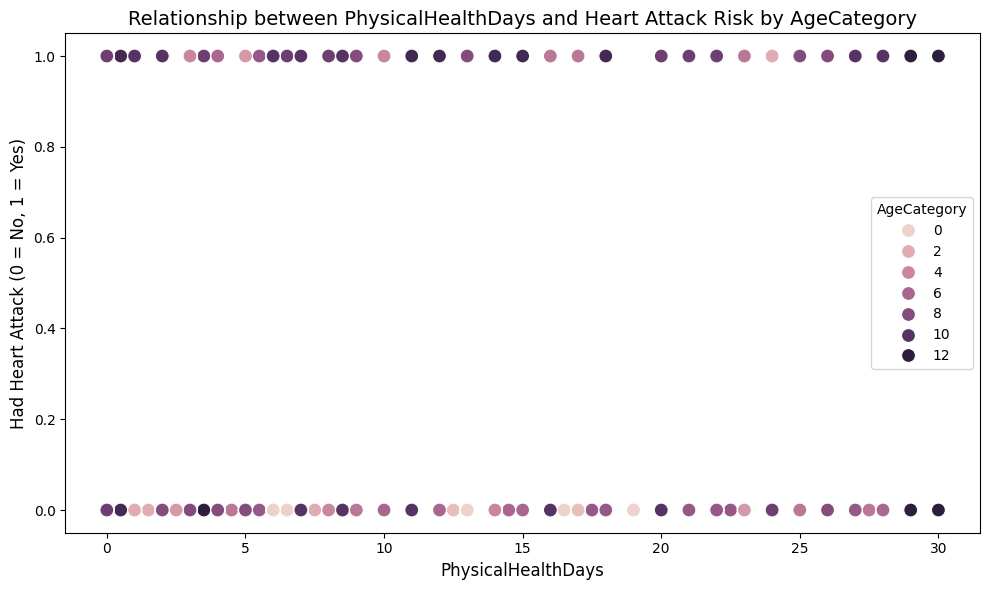

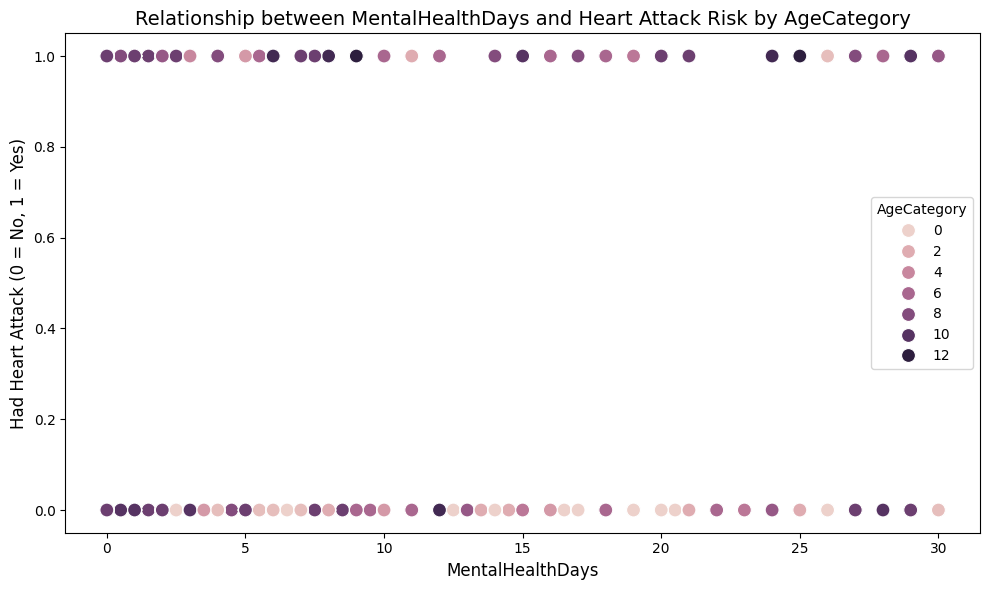

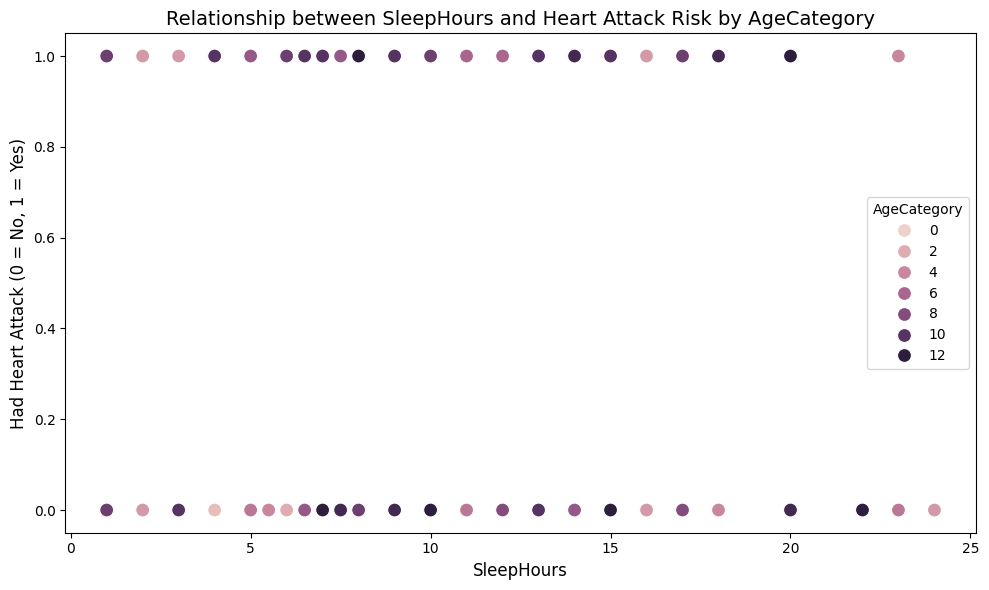

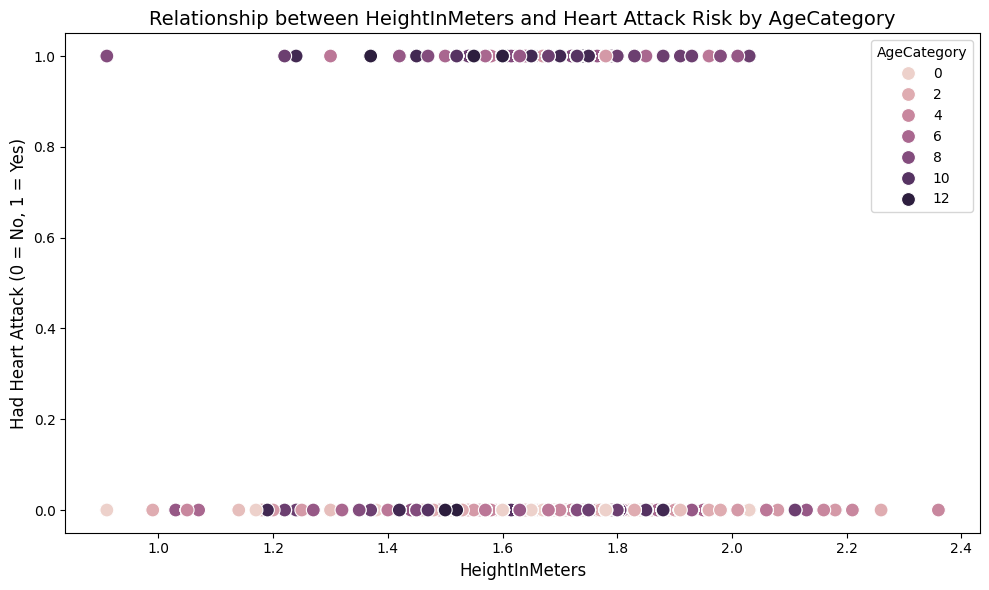

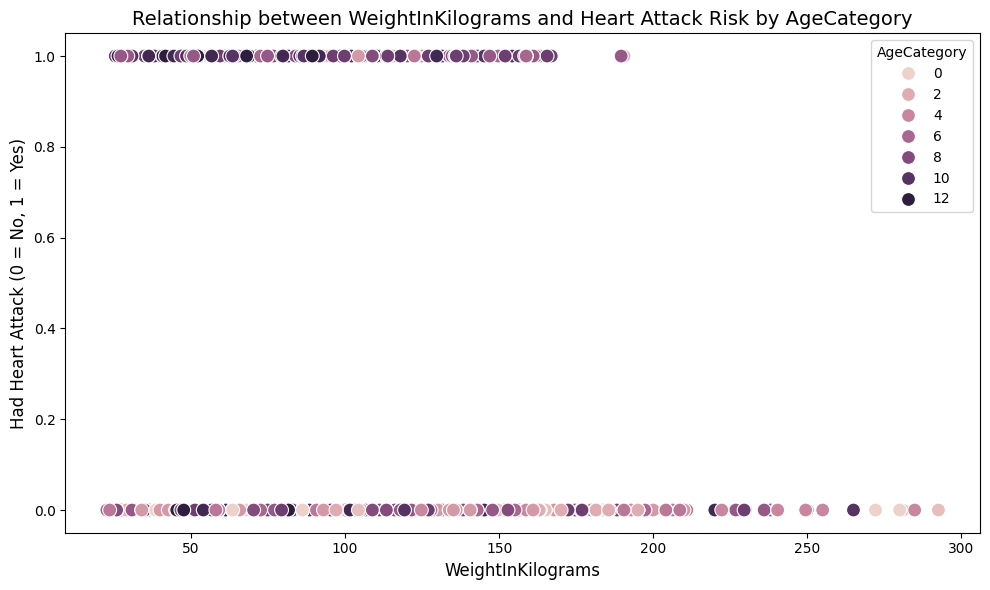

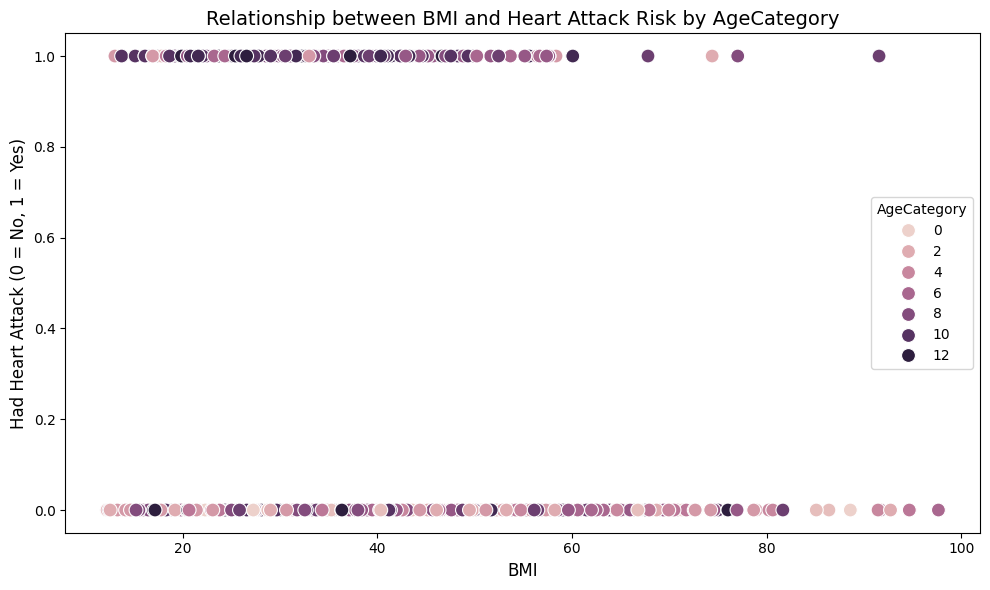

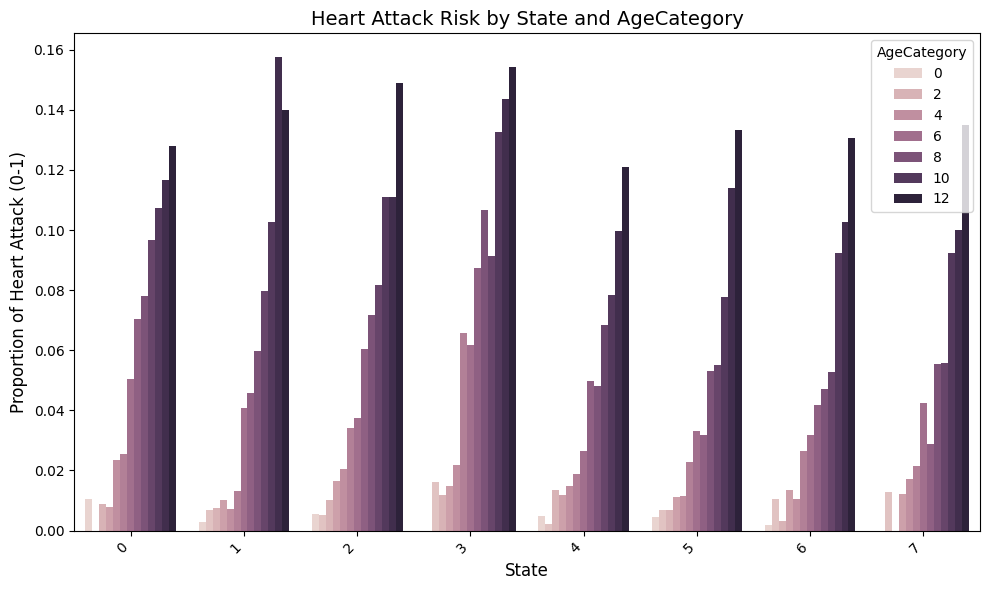

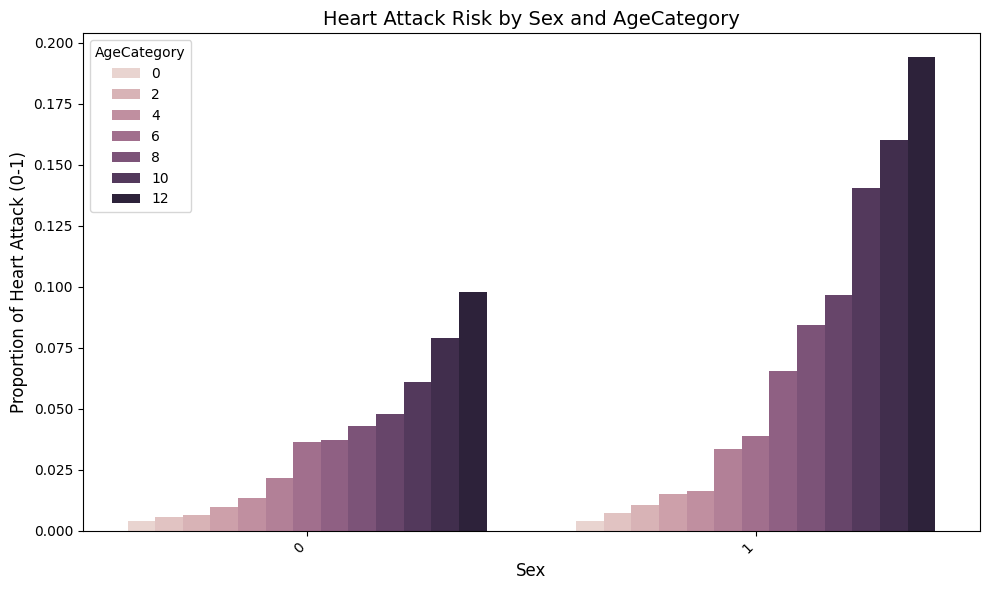

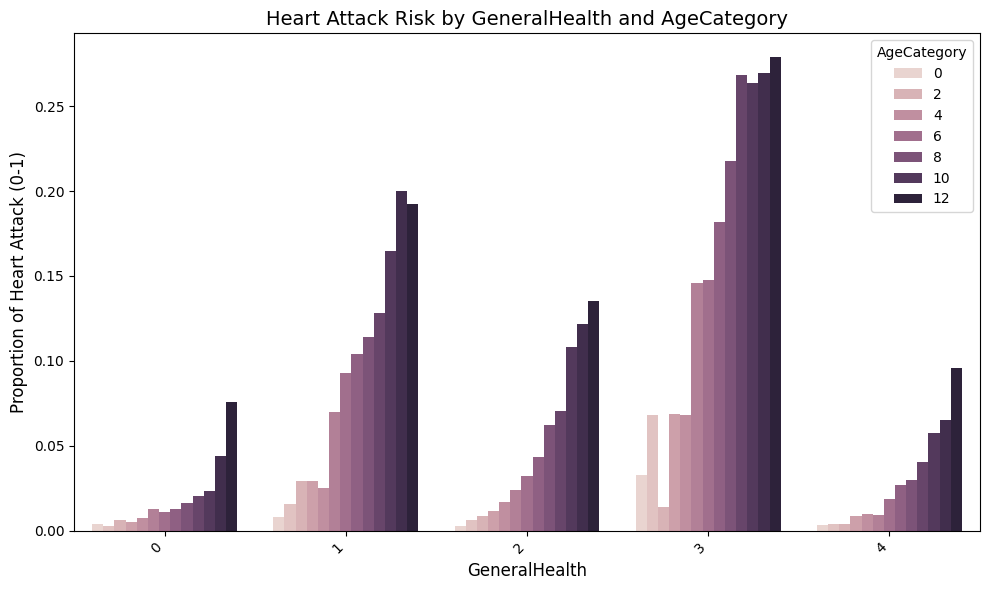

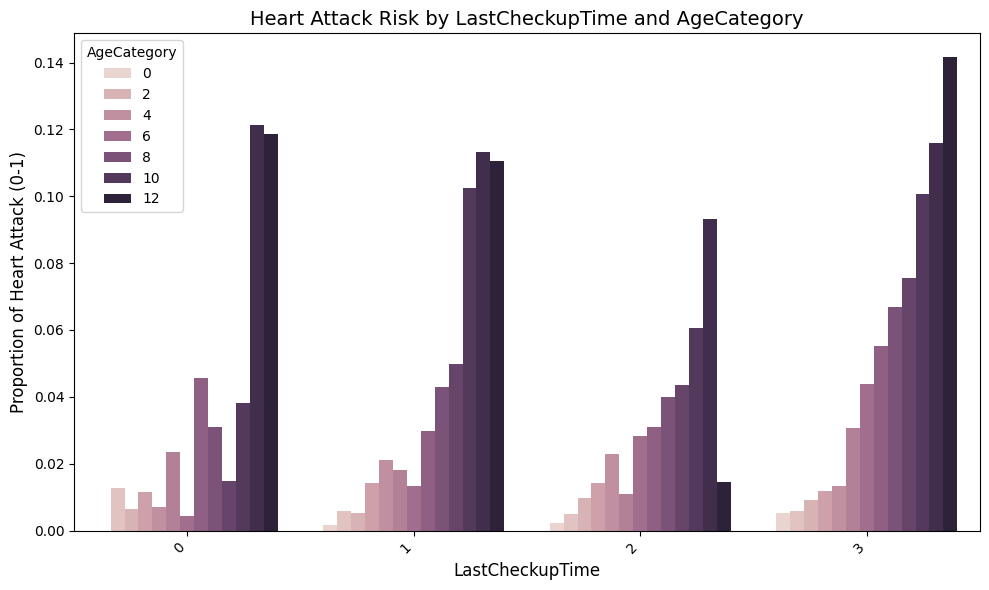

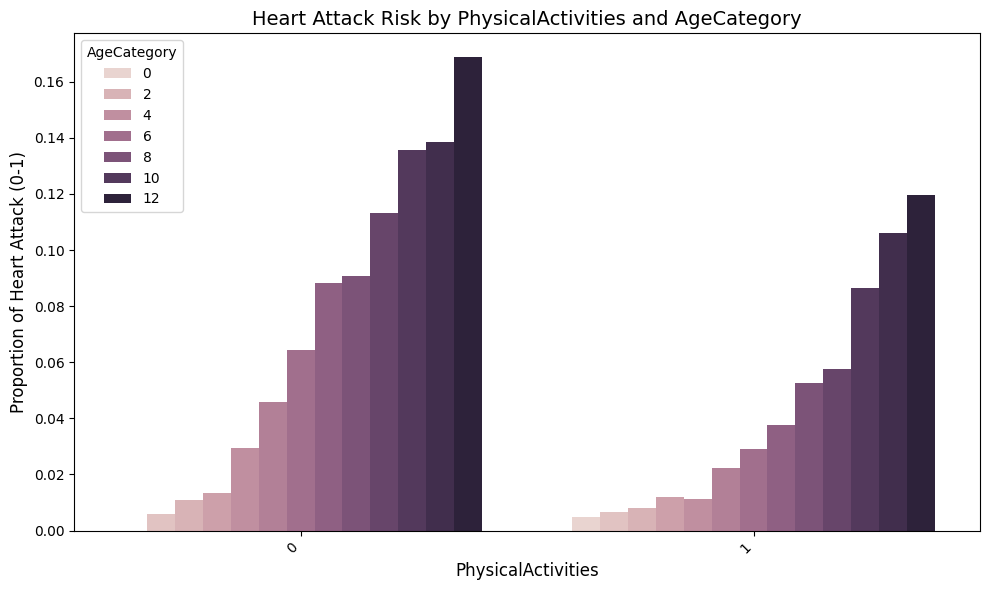

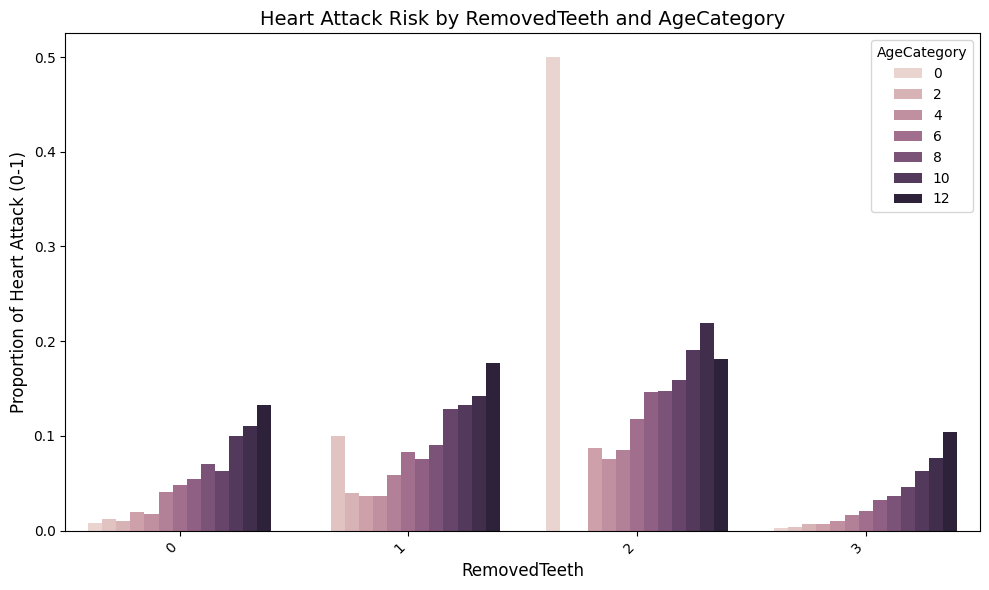

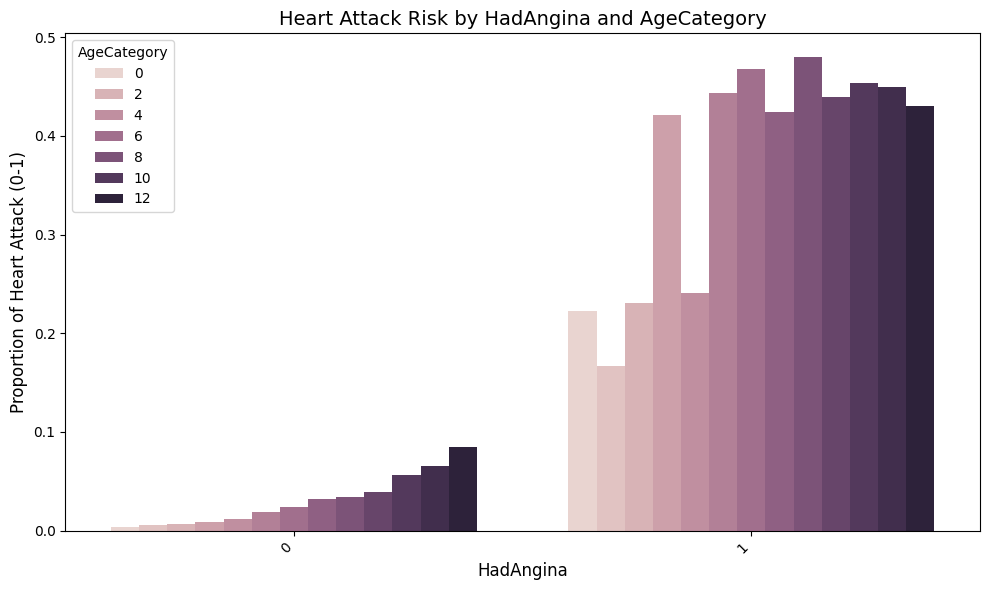

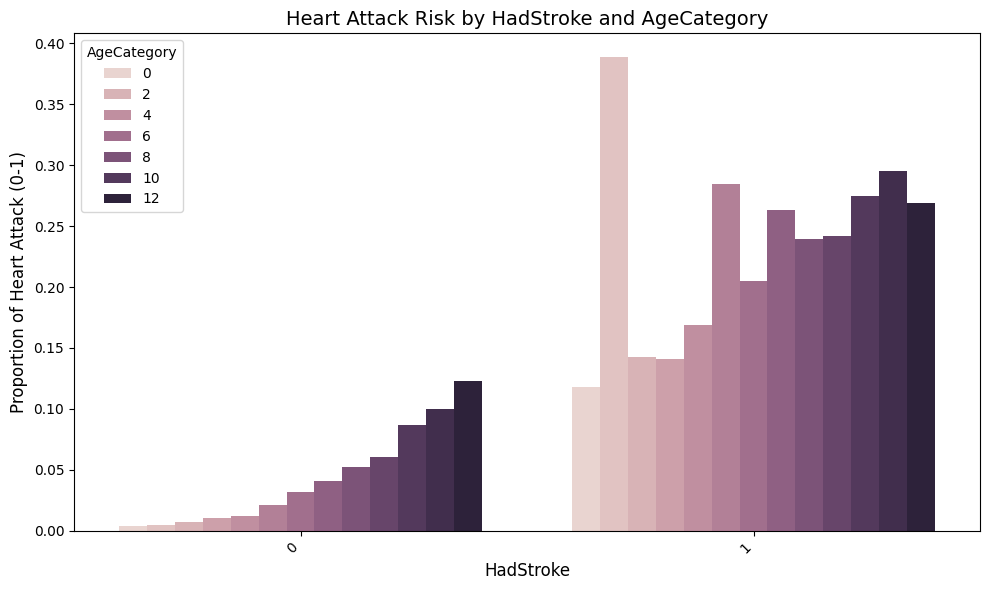

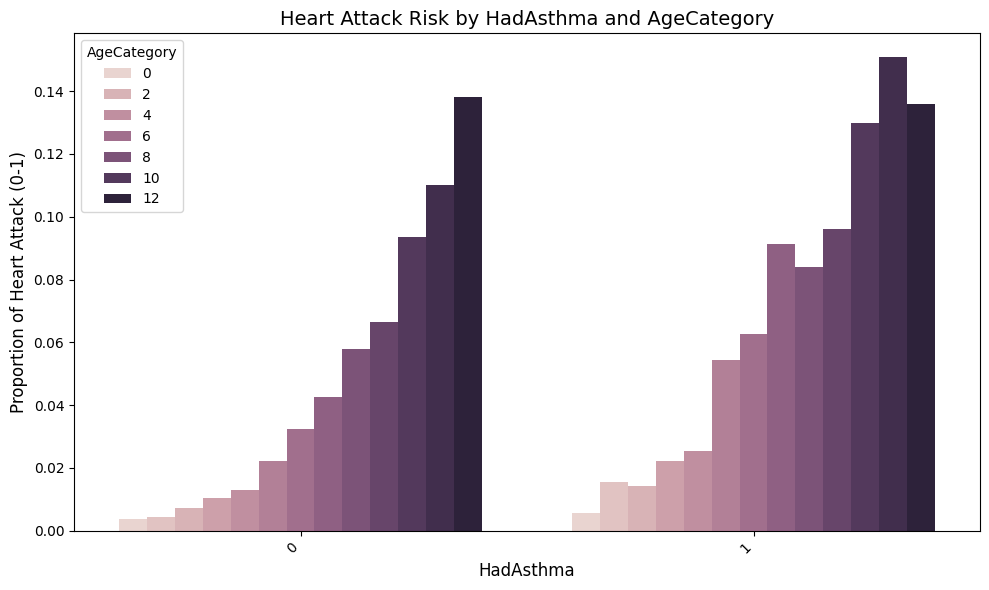

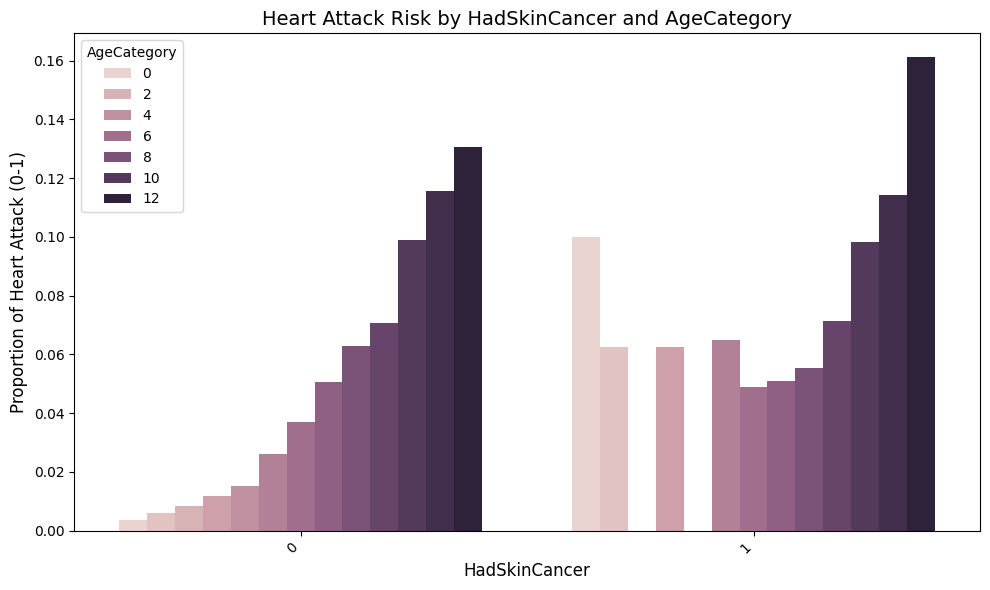

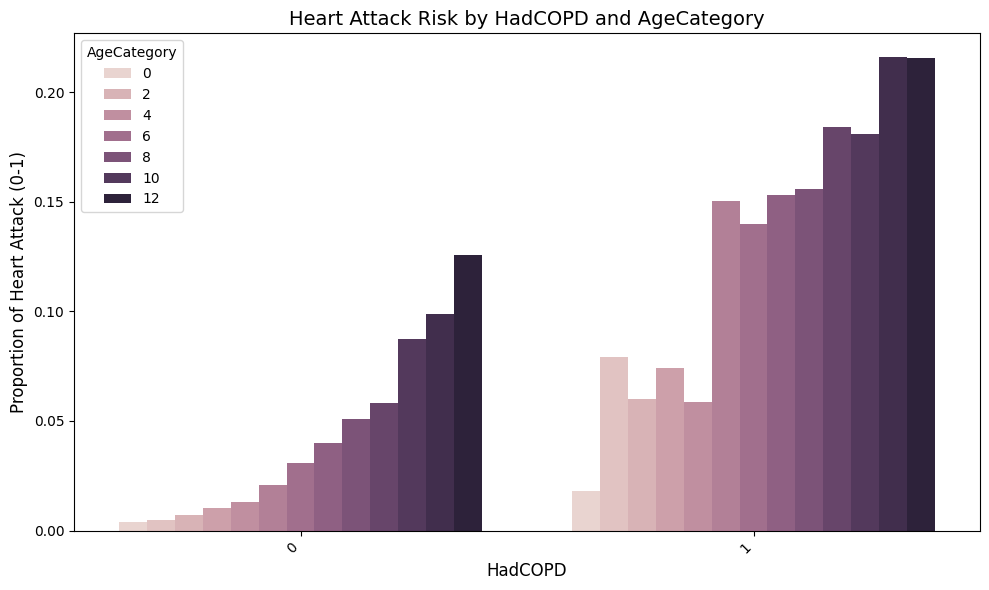

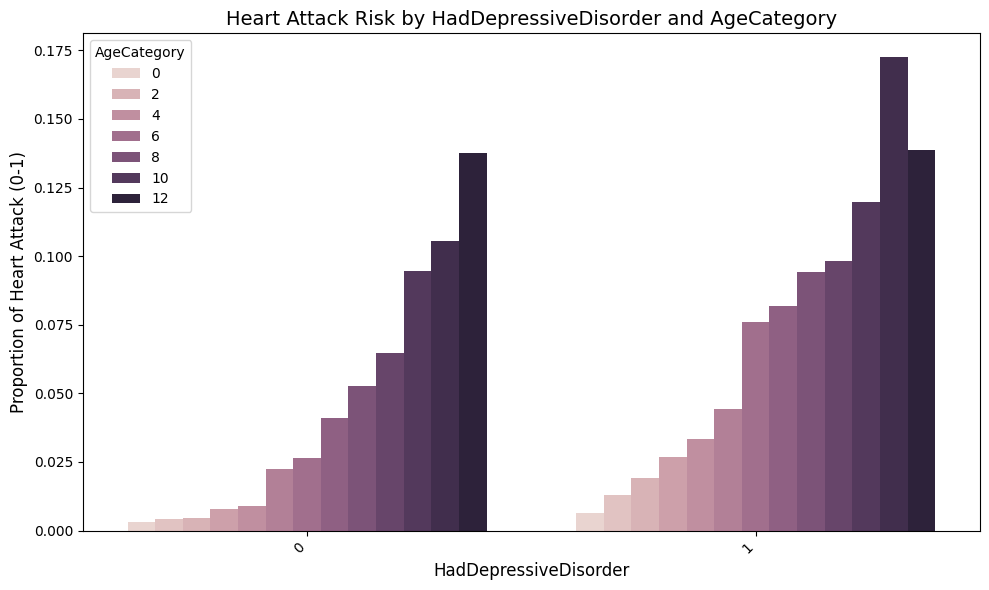

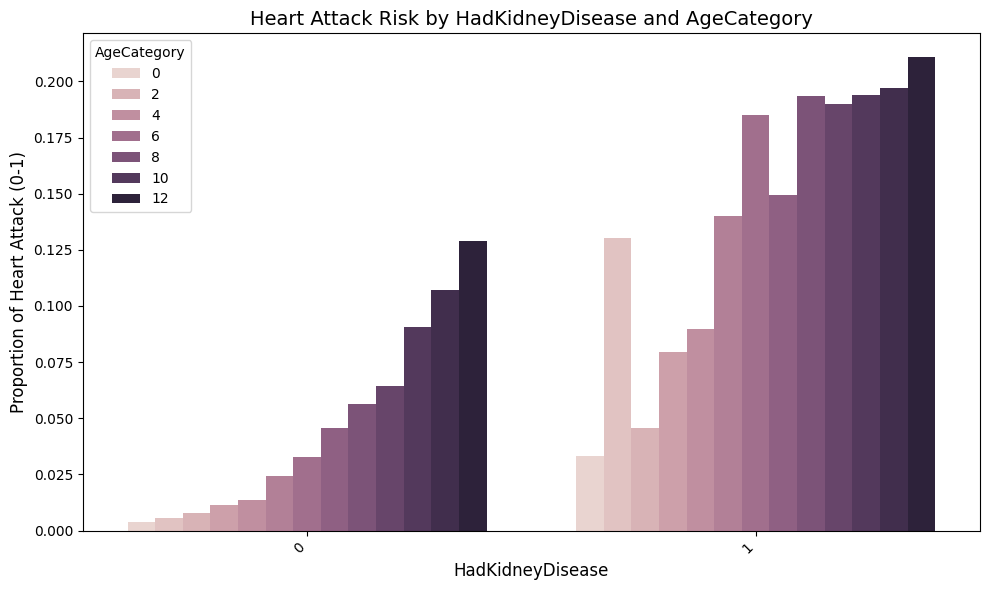

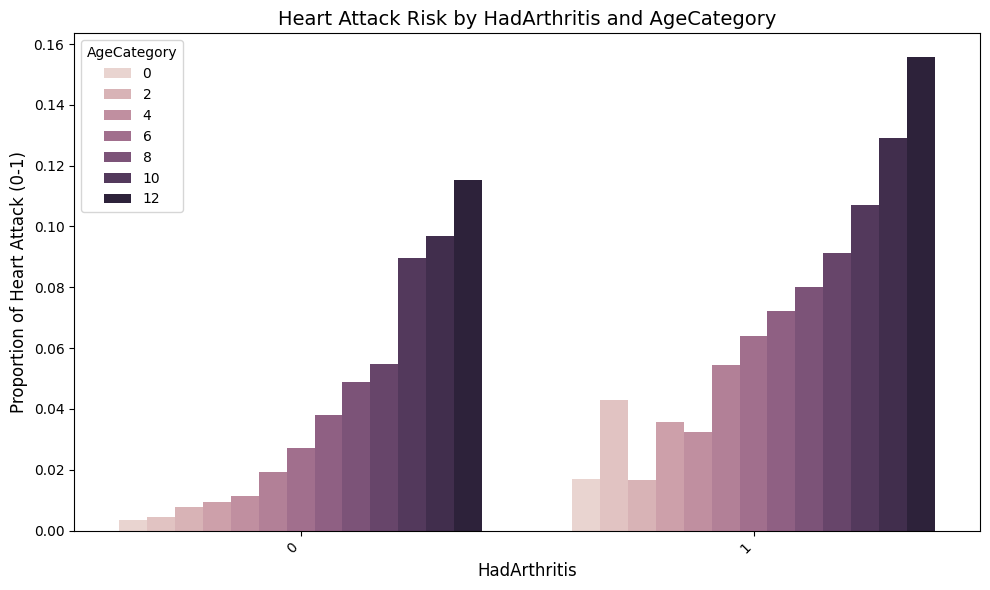

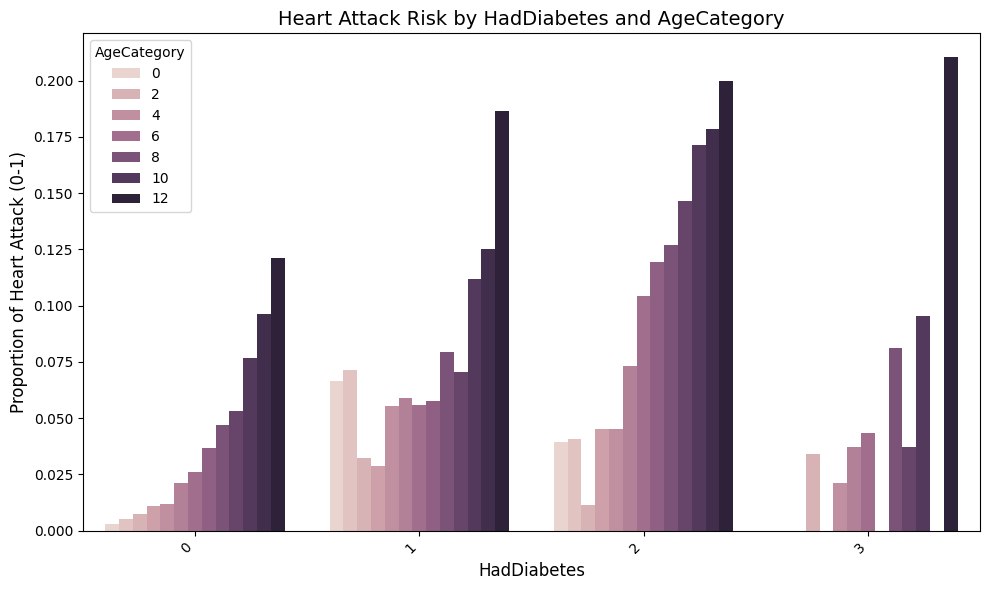

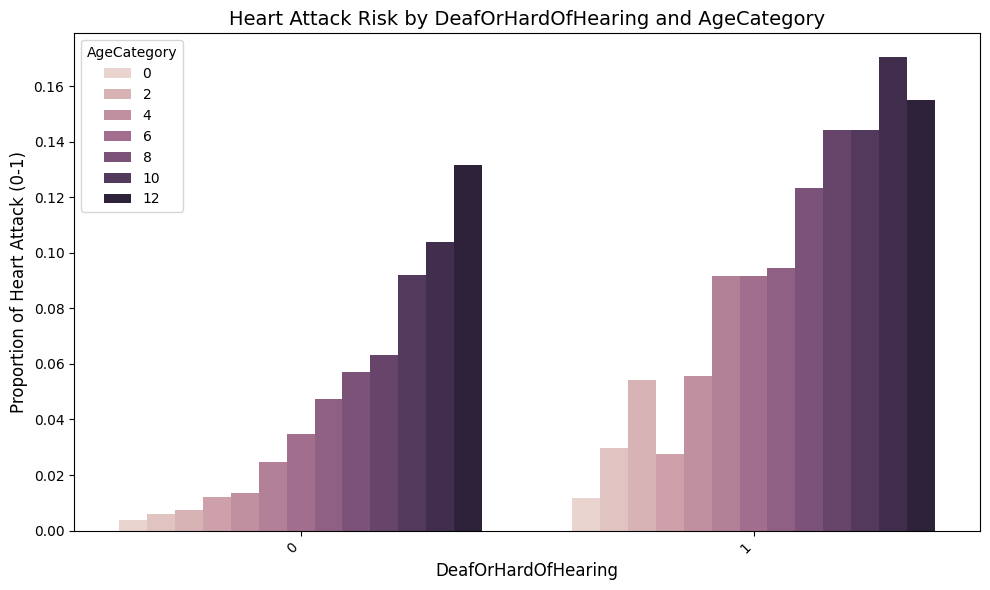

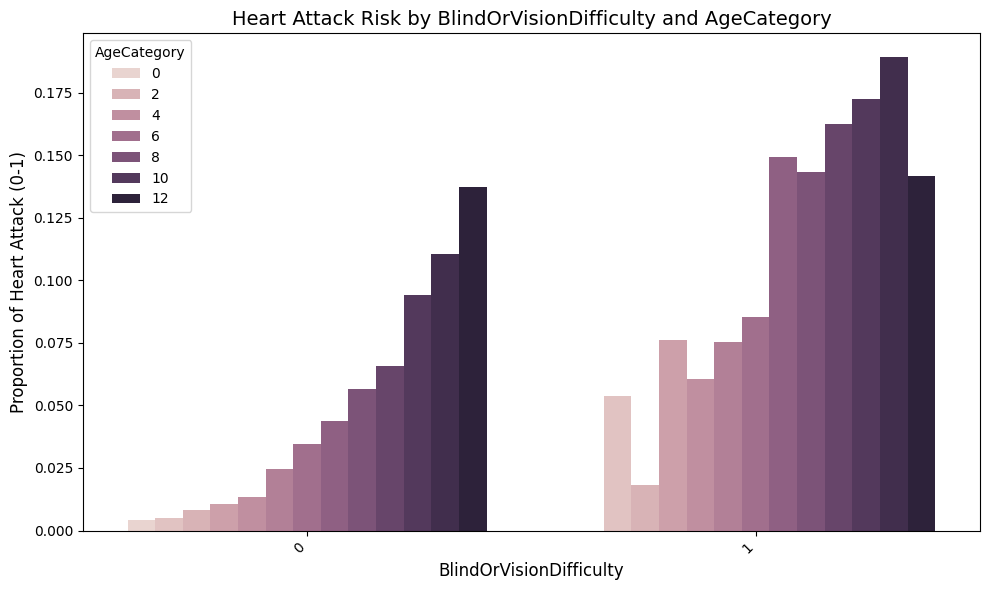

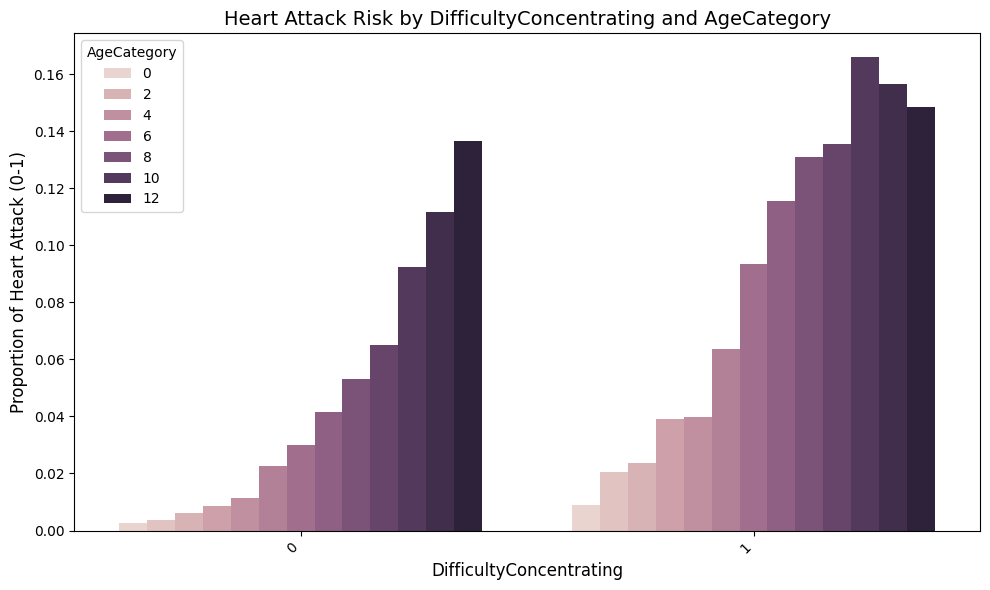

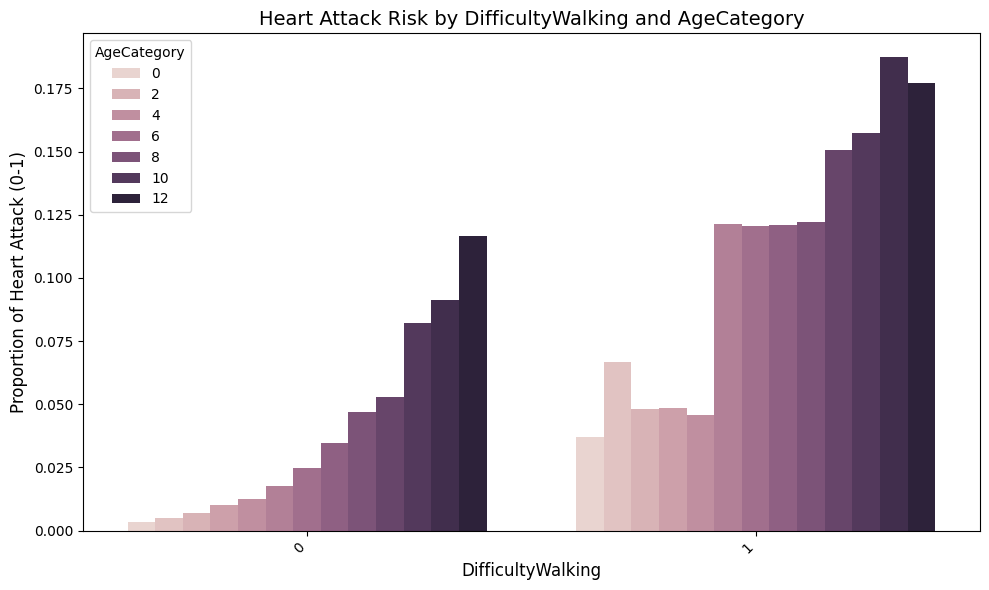

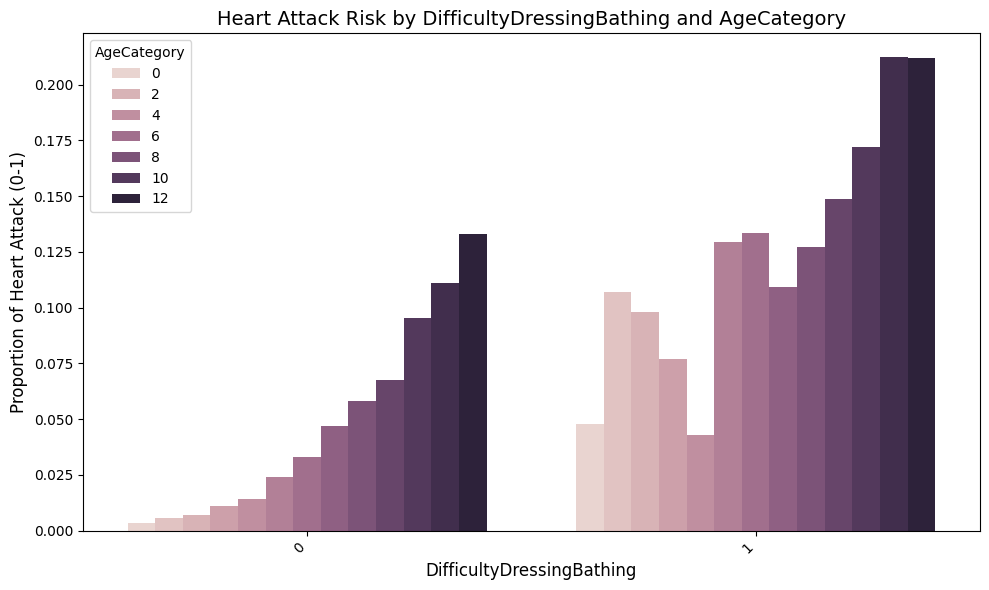

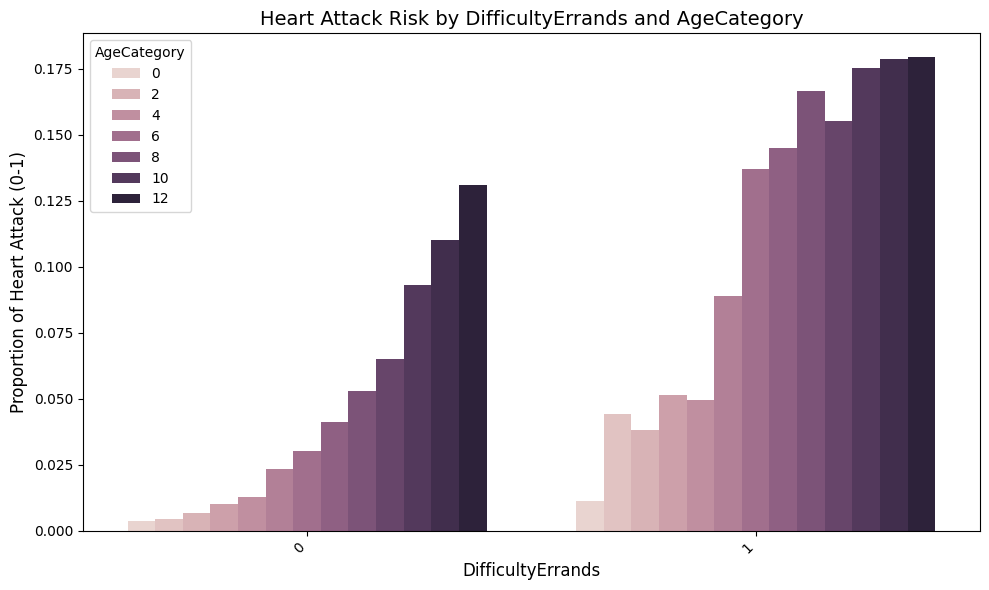

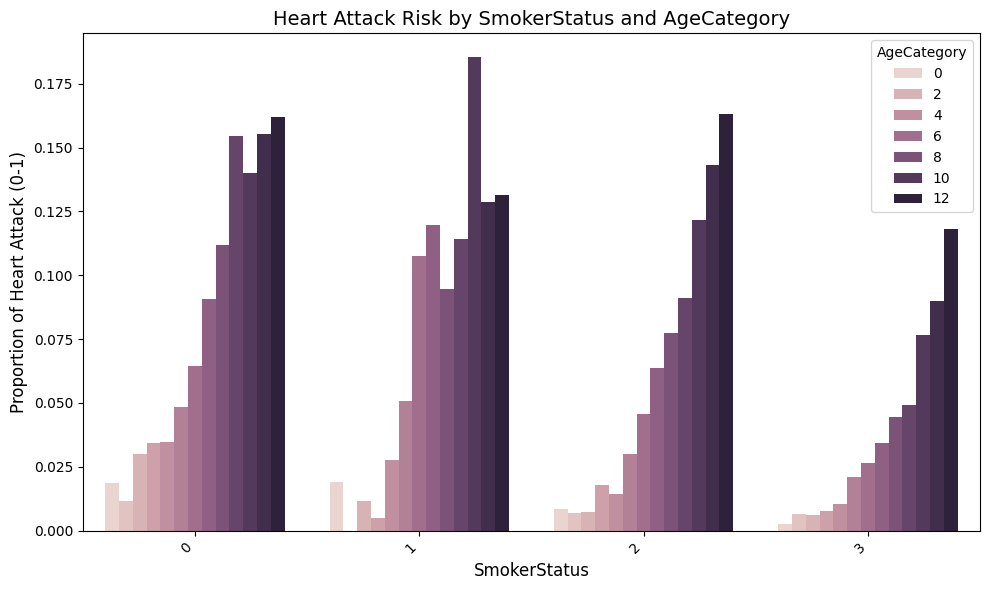

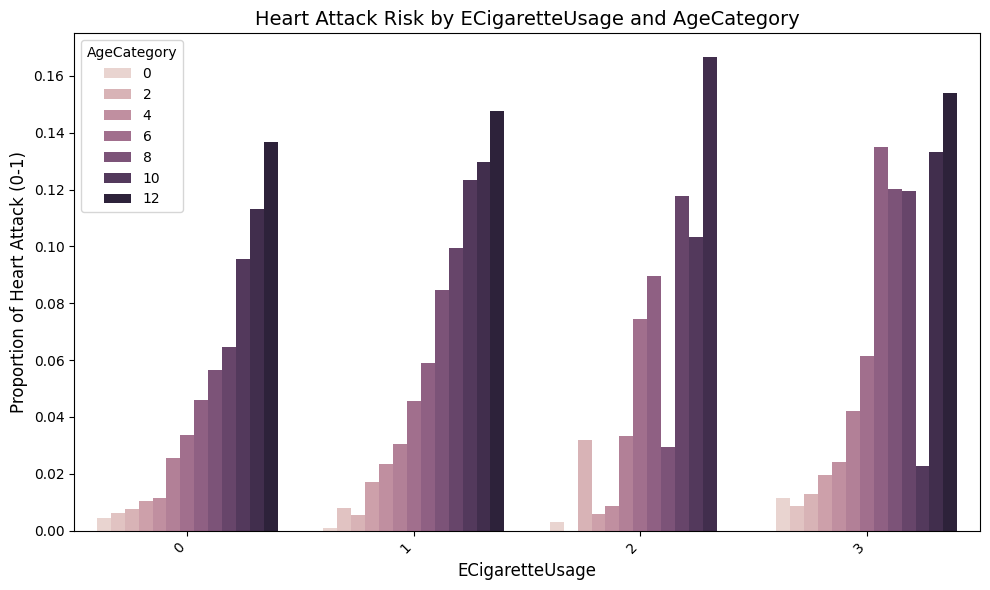

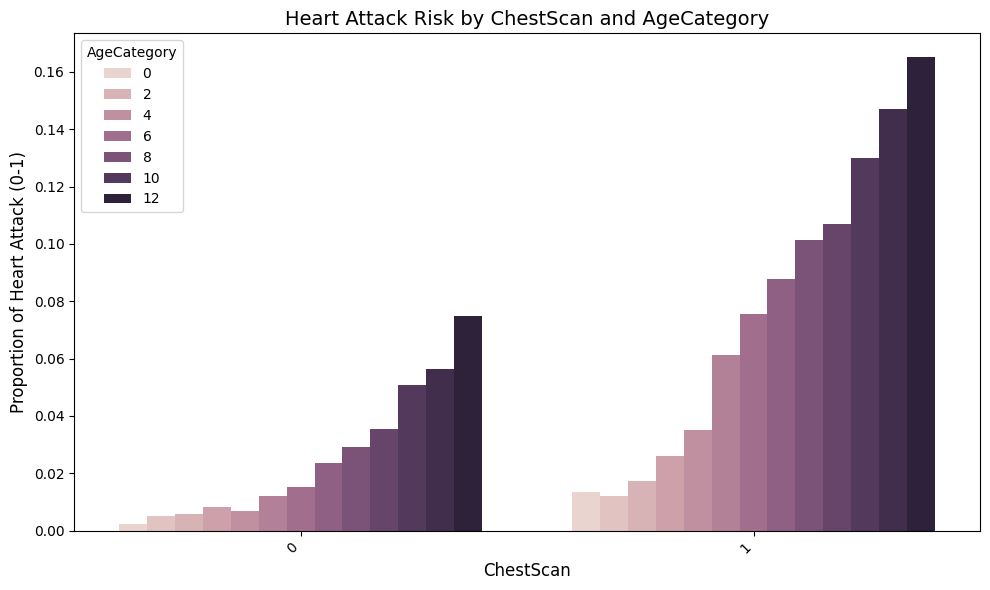

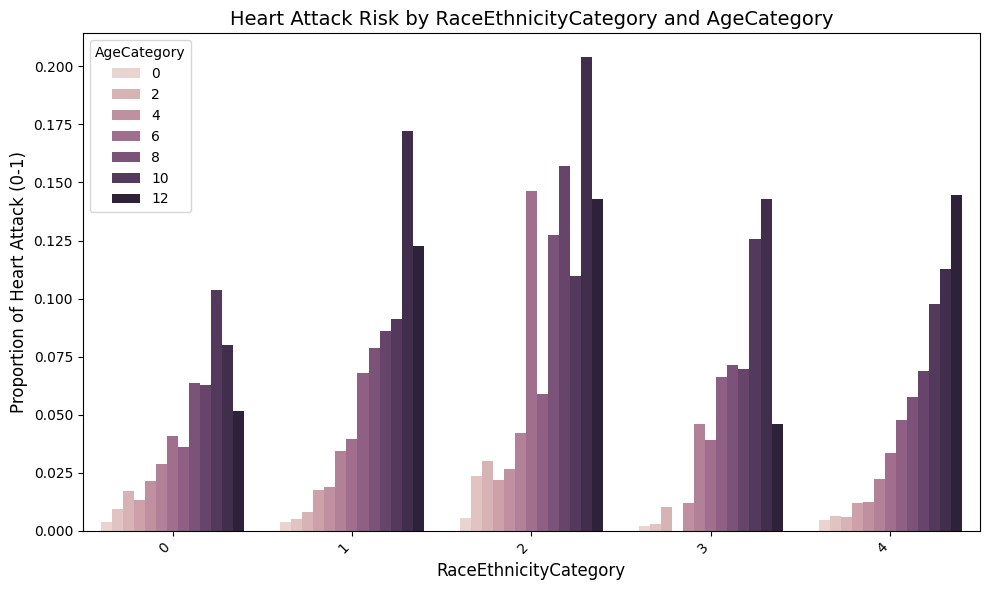

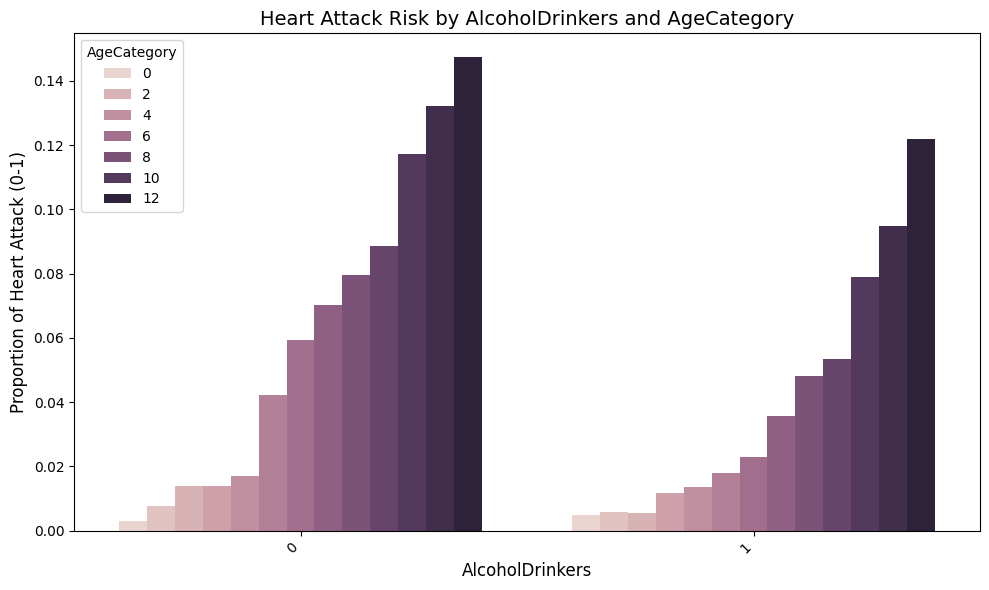

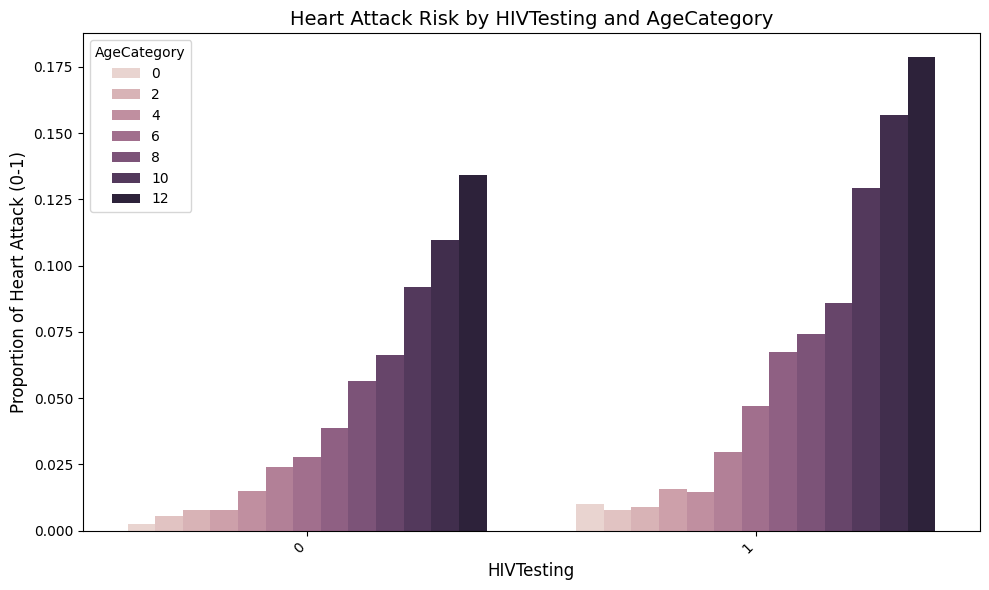

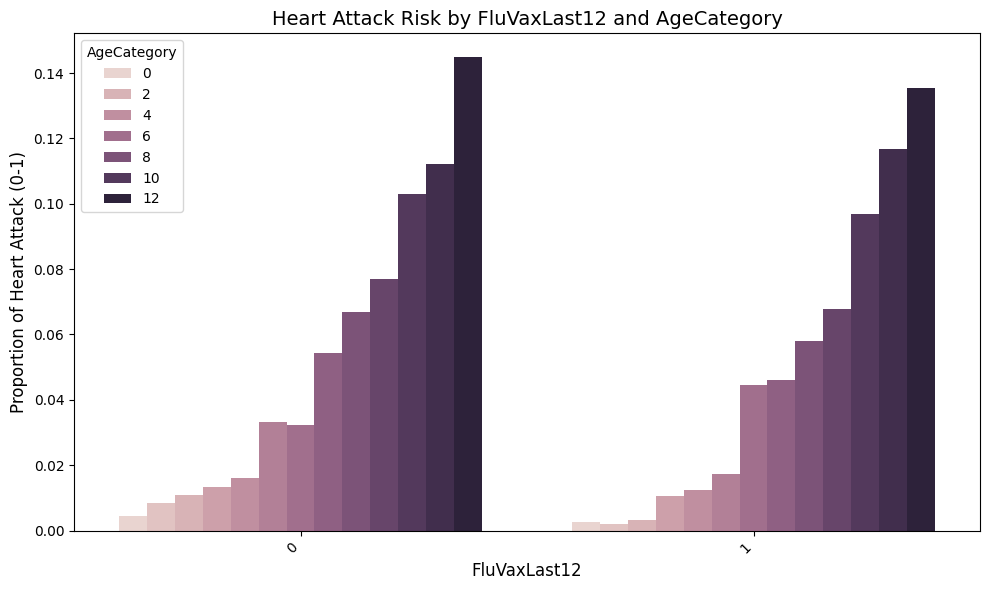

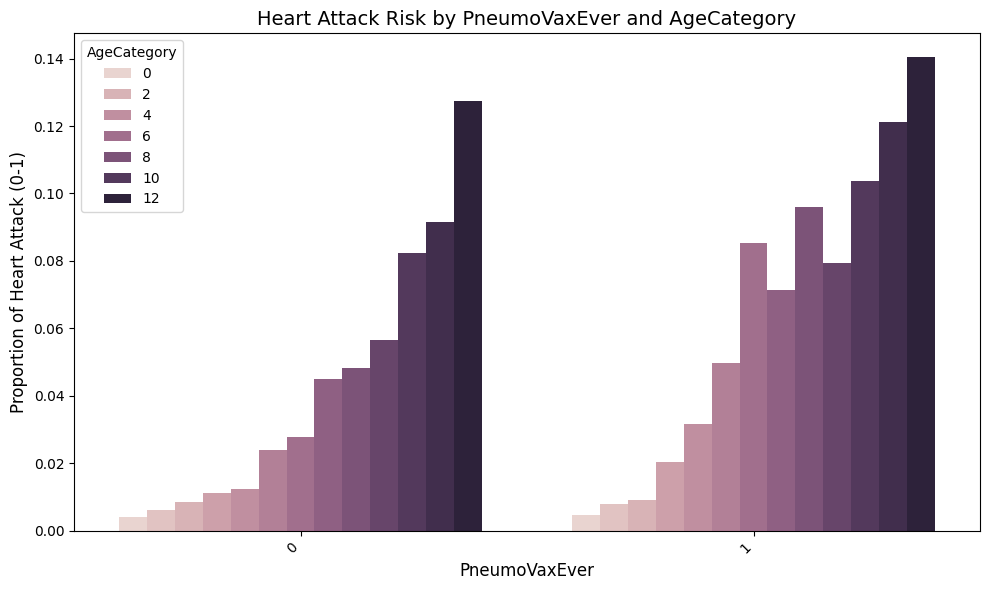

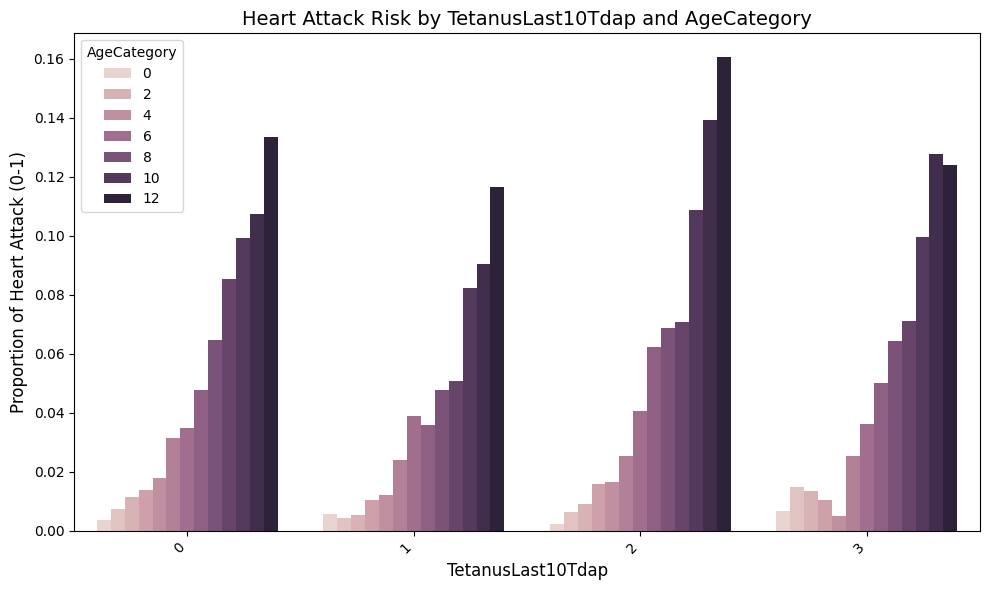

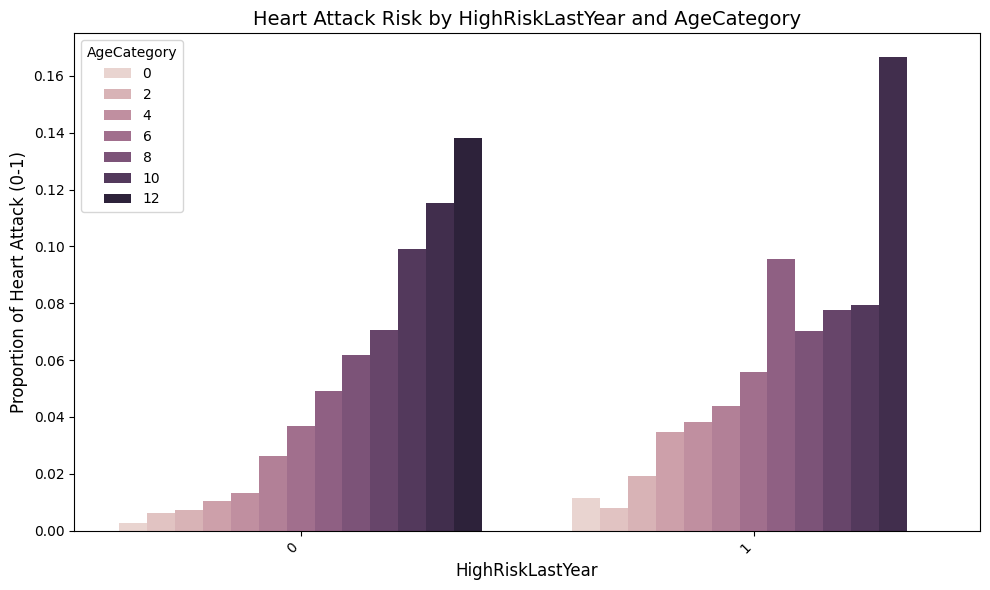

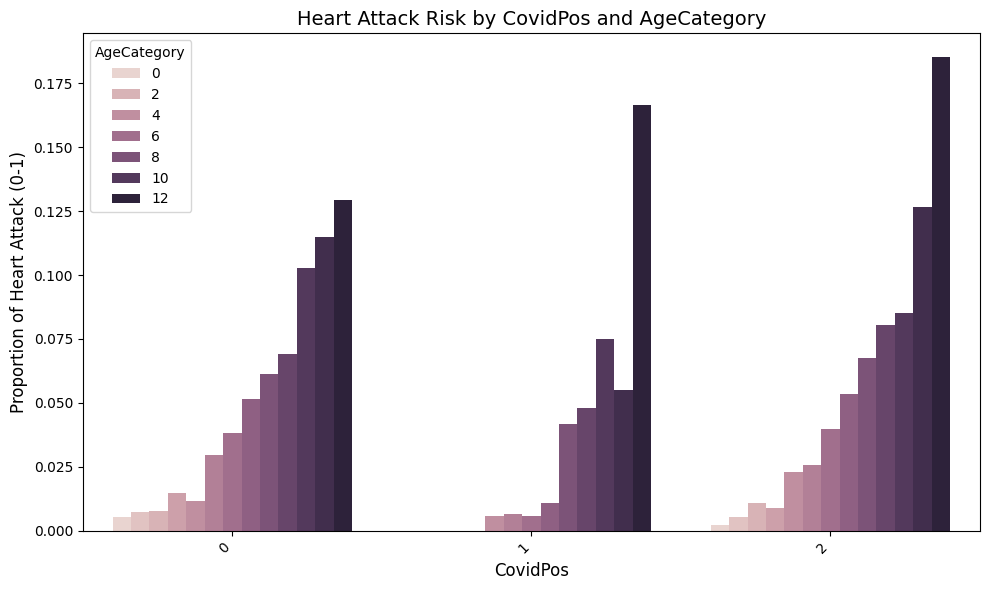

In [61]:
import seaborn as sns


# 定義特徵列表和目標變數
features = df.drop(columns="HadHeartAttack")
target = 'HadHeartAttack'

# 選擇一個主要分類變數作為交互基準
interaction_base = 'AgeCategory'

# 定義連續變數和分類變數
continuous_vars = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']
categorical_vars = [f for f in features if f not in continuous_vars and f != interaction_base]

# 1. 連續變數：散點圖觀察交互作用（與AgeCategory）
for feature in continuous_vars:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=feature, y=target, hue=interaction_base, s=100)
    plt.title(f'Relationship between {feature} and Heart Attack Risk by {interaction_base}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Had Heart Attack (0 = No, 1 = Yes)', fontsize=12)
    plt.legend(title=interaction_base)
    plt.tight_layout()
    plt.show()

# 2. 分類變數：分組條形圖觀察交互作用（與AgeCategory）
for feature in categorical_vars:
    plt.figure(figsize=(10, 6))
    # 計算每個組合下的心臟病比例
    grouped = df.groupby([feature, interaction_base])[target].mean().reset_index()
    sns.barplot(data=grouped, x=feature, y=target, hue=interaction_base)
    plt.title(f'Heart Attack Risk by {feature} and {interaction_base}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Proportion of Heart Attack (0-1)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title=interaction_base)
    plt.tight_layout()
    plt.show()

> Creating interaction terms

In [62]:
# there are related paper to support these
df["Sex_Age"] = df["Sex"] * df["AgeCategory"]
df["Weight_MentalHealthDays"] = df["WeightInKilograms"] * df["MentalHealthDays"]
df["Sex_Diabetes"] = df["Sex"] * df["HadDiabetes"]
df["AgeCategory_Diabetes"] = df["AgeCategory"] * df["HadDiabetes"]
df["BMI_Age"] = df["BMI"] * df["AgeCategory"] 
df["BMI_SleepHours"] = df["BMI"] * df["SleepHours"] 
df["SmokerStatus_Sex"] = df["SmokerStatus"] * df["Sex"]
df["SmokerStatus_Age"] = df["SmokerStatus"] * df["AgeCategory"]
df["PhysicalActivities_AgeCategory"] = df["PhysicalActivities"] * df["AgeCategory"]
df["PhysicalActivities_AgeCategory"] = df["PhysicalActivities"] * df["AgeCategory"]
df["AgeCategory_HadStroke"] = df["AgeCategory"] * df["HadStroke"]

# df["DifficultyWalking_GeneralHealth"] = df["DifficultyWalking"] * df["GeneralHealth"]
# df["BMI_DifficultyWalking"] = df["BMI"] * df["DifficultyWalking"]
# df["HadDiabetes_PhysicalActivities"] = df["HadDiabetes"] * df["PhysicalActivities"]
# df["HadKidneyDisease_PneumoVaxEver"] = df["HadKidneyDisease"] * df["PneumoVaxEver"]
# df["AlcoholDrinkers_HadAngina"] = df["AlcoholDrinkers"] * df["HadAngina"]


> Calculate features importance (test)

In [63]:
from sklearn.ensemble import RandomForestClassifier

all_terms = list(df.columns.drop("HadHeartAttack"))

X = df[all_terms]
y = df["HadHeartAttack"] 

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# 取得 Feature Importance 分數
importance_df = pd.DataFrame({
    "Term": all_terms,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# 顯示結果
display(importance_df)
condition = importance_df["Importance"] > (importance_df["Importance"].sum() / len(importance_df)) 
display(condition)

,Term,Importance
9,HadAngina,0.120063
43,BMI_Age,0.069428
44,BMI_SleepHours,0.065958
31,BMI,0.059200
30,WeightInKilograms,0.053367
29,HeightInMeters,0.043345
0,State,0.034518
7,SleepHours,0.031739
3,PhysicalHealthDays,0.029870
46,SmokerStatus_Age,0.027696


9      True
43     True
44     True
31     True
30     True
29     True
0      True
7      True
3      True
46     True
40     True
2      True
28     True
39     True
8      True
36     True
47    False
4     False
48    False
42    False
26    False
27    False
24    False
21    False
10    False
16    False
32    False
34    False
25    False
38    False
13    False
45    False
35    False
33    False
11    False
5     False
18    False
15    False
14    False
17    False
12    False
6     False
41    False
20    False
23    False
19    False
1     False
22    False
37    False
Name: Importance, dtype: bool

### Output new final data

In [16]:
output_path = '../data/cleaned/heart_2022_cleaned_02.csv'
df.to_csv(output_path, index=False)